### I had constant issues with fiona 
- at first: (specifically _GEOSArea symbol not found); this was likely something messed up with my GDAL path due to installations of QGIS and gdal conflicting... [src]
- after that: i tried to uninstall fiona, etc. go that route again b/c it had worked before... but in between doing this i updated my OS to High Sierra
- then I had problems with pip in general, potentially an SSL cert issue between pip/LibreSSL (the installed version of OpenSSL with High Sierra)
- for the life of me i couldn't get anything to work
- final solution was to switch to homebrew and use virtualenvs, then creating a custom kernel from the virtualenv
- note: this virtual env was created with access to site packages. im not sure why regular python2 kernels wont work (it is likely due to wrong setup in kernel.json, i.e. it doesnt point to correct python env [http://jupyter-client.readthedocs.io/en/stable/kernels.html])


In [2]:
import fiona
import osmnx as ox

In [3]:
import shapely
import math
import pyproj
import sys

import numpy as np
import matplotlib.pyplot as plt, pandas as pd, geopandas as gpd

from matplotlib import pyplot
from functools import partial
from shapely import geometry
from shapely.ops import transform
from descartes import PolygonPatch
from matplotlib.patches import Arc
from shapely.geometry import Point, Polygon, MultiPolygon
%matplotlib inline

### CUSTOM CLASSES
sys.path.append('../../../alg')
import distance_buffer as db
import border_generators as bg


In [4]:
reload(bg)

<module 'border_generators' from '../../../alg/border_generators.pyc'>

In [5]:
reload(db)

<module 'distance_buffer' from '../../../alg/distance_buffer.pyc'>

## Get the place and show it

In [6]:
gdf, placegeom = bg.getplace('Walnut Creek, California, USA')

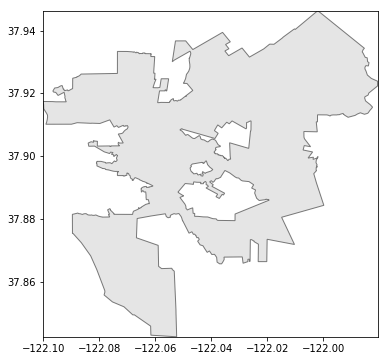

In [7]:
# plot the city
west, south, east, north = gdf.unary_union.bounds
fig, ax = plt.subplots(figsize=(6,6))
for polygon in placegeom:
    patch = PolygonPatch(polygon, fc='#cccccc', ec='k', alpha=0.5, zorder=2)
    ax.add_patch(patch)
    
ax.set_xlim(west, east)
ax.set_ylim(south, north)
#ax.axis('off')
plt.show()

In [8]:
proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),pyproj.Proj(init='epsg:3857'))
transgeom = transform(proj, placegeom)

## Try to find the relative inflection points of the polygon

In [9]:
def find_infl_pts(coordlist):
    
    l = len(coordlist)
    inflpts = []
    rad = 100
    for i in range(0, l-1):
        a = coordlist[i]
        b = coordlist[i+1]
        if i==l-2:           # final iteration, loop back around for final point
            c = coordlist[0]
        else:
            c = coordlist[i+2]
        ang =numpy.rad2deg(ang_between(a,b,c))
        #ang = numpy.rad2deg(ang_bw_vectorst(a, b, c, b))
        #print str(ang)+"  from "+str(from1)+"  to "+str(to1)+"   to2 "+str(to2)
        l1 = db.eucdist(a[0],a[1],b[0],b[1])
        l2 = db.eucdist(b[0],b[1],c[0],c[1])
        #print ang
        if ang <= 125.0 and ang >= -125.0 and (l1[0]>=rad or l2[0]>=rad):
            inflpts.append(b)
            print ang
        #else:
            #print f1, t1, t2
            #print ang
            #print i
            
    return inflpts
    

## Find correct way to measure interior angles

In [10]:
extcoords = transgeom[0].exterior.coords
first30 = []
for i in range(0, 100):
    first30.append(extcoords[i])


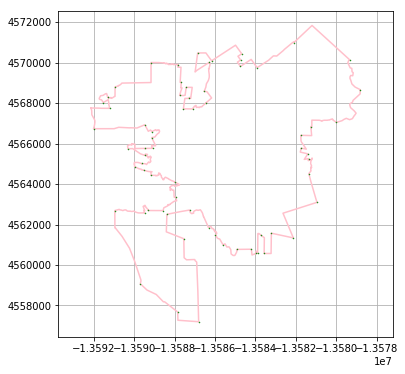

In [99]:
a = extcoords[15]
b= extcoords[16]
c=extcoords[17]
fig2, ax2=plt.subplots(figsize=(6,6))
ax2.plot(zip(*extcoords)[0], zip(*extcoords)[1], color='pink')

#for arc in arcs:
#    ax2.add_patch(arc)
    

#ax2.scatter(zip(*inflpts)[0],zip(*inflpts)[1] )
#ax2.scatter([a[0],b[0],c[0]],[a[1],b[1],c[1]], color='green')
ax2.scatter(zip(*v2markdegs)[0], zip(*v2markdegs)[1], s=0.25, color='green', zorder=4)
plt.axis('equal')
ax2.grid(True, which='both')
plt.savefig('WalnutCreekCA__marked_v2_2', dpi=192 * 10)

plt.show()

In [64]:
arcs = []
degs = []
markdegs = []
for i in range(0,len(extcoords)-1):
    
    a = extcoords[i]
    b = extcoords[i+1]
    c = extcoords[i+2]
    l1 = db.eucdist(a[0],a[1],b[0],b[1])[0]
    l2 = db.eucdist(b[0],b[1],c[0],c[1])[0]
    ml = min(l1,l2)
    

    ang, thetas =angle_between(a,b,c)
   
    
    
    arcs.append(Arc(b, ml, ml, theta1=thetas[0], theta2=thetas[1]))
    if thetas[0] < 0.0:
        thetas[0]+=360
    if thetas[1] < 0.0:
        thetas[1]+=360
    tdeg = abs(thetas[1]-thetas[0])
    print str(thetas[1]) + "  -  "+str(thetas[0])+"  =  "+str(tdeg)
    if tdeg <= 130.0 or tdeg >= 230.0:
        markdegs.append(b)
    degs.append(tdeg)
    

103.89192522919508
-77.74916884251388
181.64109407170895
103.89192522919508  -  282.2508311574861  =  178.35890592829105
102.25083115748612
-88.59670763393413
190.84753879142025
102.25083115748612  -  271.4032923660659  =  169.15246120857978
91.40329236606587
-60.79366490627254
152.1969572723384
91.40329236606587  -  299.2063350937275  =  207.80304272766162
119.20633509372746
-66.02515315611744
185.23148824984492
119.20633509372746  -  293.9748468438826  =  174.7685117501551
113.97484684388256
-87.3468708922054
201.32171773608798
113.97484684388256  -  272.6531291077946  =  158.67828226391202
92.65312910779461
-97.04115303619146
189.69428214398607
92.65312910779461  -  262.9588469638085  =  170.30571785601393
82.95884696380854
-101.75579288775305
184.71463985156157
82.95884696380854  -  258.24420711224695  =  175.28536014843843
78.24420711224697
-109.21479998796485
187.4590071002118
78.24420711224697  -  250.78520001203515  =  172.5409928997882
70.78520001203516
0.07851118740799484
70.

-179.4206383952077
89.9941831058837
90.58517849890859
180.5793616047923  -  89.9941831058837  =  90.58517849890859
-90.00581689411631
-19.956441190637626
289.9506242965213
269.9941831058837  -  340.04355880936237  =  70.04937570347869
160.0435588093624
-23.057913610407805
183.1014724197702
160.0435588093624  -  336.9420863895922  =  176.8985275802298
156.94208638959222
-49.336550563822954
206.27863695341517
156.94208638959222  -  310.6634494361771  =  153.72136304658486
130.66344943617705
-82.03059408940595
212.694043525583
130.66344943617705  -  277.96940591059405  =  147.305956474417
97.96940591059406
-43.3165321153409
141.28593802593497
97.96940591059406  -  316.6834678846591  =  218.71406197406503
136.6834678846591
-88.37251906566483
225.05598695032393
136.6834678846591  -  271.62748093433515  =  134.94401304967604
91.62748093433518
-70.20922469856735
161.83670563290252
91.62748093433518  -  289.79077530143263  =  198.16329436709745
109.79077530143266
-48.40981429609598
158.2005895

-169.757142803145
9.715619211116055
180.52723798573894
190.242857196855  -  9.715619211116055  =  180.52723798573894
-170.28438078888396
9.761567181936304
179.95405202917973
189.71561921111604  -  9.761567181936304  =  179.95405202917973
-170.2384328180637
-73.93801005898221
263.69957724091853
189.7615671819363  -  286.06198994101777  =  96.30042275908147
106.06198994101779
-36.252783867606084
142.31477380862387
106.06198994101779  -  323.74721613239393  =  217.68522619137616
143.74721613239393
16.29637423371547
127.45084189867846
143.74721613239393  -  16.29637423371547  =  127.45084189867846
-163.70362576628452
105.14269595904862
91.15367827466685
196.29637423371548  -  105.14269595904862  =  91.15367827466686
-74.85730404095138
53.63287246770273
231.50982349134588
285.14269595904864  -  53.63287246770273  =  231.5098234913459
-126.36712753229726
25.09518525351662
208.53768721418612
233.63287246770273  -  25.09518525351662  =  208.5376872141861
-154.9048147464834
-15.39610017076386
2

-72.97600374430174
114.5659313593702
172.45806489632807
287.02399625569825  -  114.5659313593702  =  172.45806489632804
-65.4340686406298
90.12659351182926
204.43933784754094
294.5659313593702  -  90.12659351182926  =  204.43933784754097
-89.87340648817074
61.69379464055782
208.43279887127144
270.12659351182924  -  61.69379464055782  =  208.43279887127142
-118.30620535944219
-9.064479806819547
250.75827444737735
241.69379464055783  -  350.9355201931805  =  109.24172555262265
170.93552019318045
80.13778718856203
90.79773300461842
170.93552019318045  -  80.13778718856203  =  90.79773300461842
-99.86221281143797
140.81751253651404
119.320274652048
260.137787188562  -  140.81751253651404  =  119.32027465204797
-39.18248746348597
94.44620918803753
226.3713033484765
320.817512536514  -  94.44620918803753  =  226.3713033484765
-85.55379081196247
164.19328676208124
110.25292242595629
274.4462091880375  -  164.19328676208124  =  110.25292242595629
-15.806713237918768
114.5294624024208
229.66382

8.965872301293135  -  241.90504294994219  =  232.93917064864905
61.9050429499422
-85.94669949474516
147.85174244468737
61.9050429499422  -  274.0533005052548  =  212.14825755531263
94.05330050525485
-41.743686458065504
135.79698696332036
94.05330050525485  -  318.2563135419345  =  224.20301303667964
138.2563135419345
-2.1920946723217214
140.44840821425623
138.2563135419345  -  357.80790532767827  =  219.55159178574377
177.8079053276783
-32.855440321541046
210.66334564921934
177.8079053276783  -  327.14455967845896  =  149.33665435078066
147.14455967845896
-56.74434180247451
203.88890148093347
147.14455967845896  -  303.25565819752546  =  156.1110985190665
123.25565819752549
30.601155127087807
92.65450307043768
123.25565819752549  -  30.601155127087807  =  92.65450307043768
-149.39884487291218
-79.44399074365353
290.04514587074135
210.60115512708782  -  280.55600925634644  =  69.95485412925862
100.55600925634647
-94.48512461778265
195.04113387412912
100.55600925634647  -  265.5148753822

IndexError: index out of range

In [96]:


def inflpts_v2(polycoords, r):
    arcs = []
    degs = []
    markdegs = []
    
    dist_last_pt = 0.0
    
    for i in range(0,len(polycoords)-2):
    
        a = polycoords[i]
        b = polycoords[i+1]
        c = polycoords[i+2]
        l1 = db.eucdist(a[0],a[1],b[0],b[1])[0]
        l2 = db.eucdist(b[0],b[1],c[0],c[1])[0]
        #ml = min(l1[0],l2)
        
        d = math.sqrt(3)*r

        ang, thetas =angle_between(a,b,c)
   
    
    
        arcs.append(Arc(b, ml, ml, theta1=thetas[0], theta2=thetas[1]))
        if thetas[0] < 0.0:
            thetas[0]+=360
        if thetas[1] < 0.0:
            thetas[1]+=360
            
        tdeg = abs(thetas[1]-thetas[0])
        
        # mark this as inflection point if it meets the following conditions
        # otherwise, we link edges til we get an infl. pt
        print l1
        print l2
        print dist_last_pt
        
        if (tdeg <= 130.0 or tdeg >= 230.0) and (dist_last_pt >= d) and (l1 >= d or l2 >= d):
            markdegs.append(b)
            dist_last_pt = 0.0
        else:
            dist_last_pt += l1
            
        
        degs.append(tdeg)
        
    print len(markdegs)
    return markdegs

In [97]:
v2markdegs = inflpts_v2(extcoords, 100.0)


103.89192522919508
88.4653651837
48.6320133363
0.0
102.25083115748612
48.6320133363
197.732636959
88.4653651837
91.40329236606587
197.732636959
235.867948298
137.09737852
119.20633509372746
235.867948298
82.4618139396
334.830015479
113.97484684388256
82.4618139396
84.6512427389
570.697963776
92.65312910779461
84.6512427389
124.412585849
653.159777716
82.95884696380854
124.412585849
123.754655559
737.811020455
78.24420711224697
123.754655559
86.1844264672
862.223606304
70.78520001203516
86.1844264672
1019.37579812
985.978261863
-179.921488812592
1019.37579812
236.97353475
0.0
-163.3296889898588
236.97353475
145.312284021
1019.37579812
177.02230494705432
145.312284021
416.129152565
1256.34933287
177.17223160531432
416.129152565
11.8510495762
1401.66161689
-149.6819679425809
11.8510495762
332.076133757
1817.79076945
177.85477949478943
332.076133757
422.477878951
1829.64181903
-157.5239889382019
422.477878951
365.85730878
2161.71795279
117.74869218546137
365.85730878
126.749224553
0.0
-150

1016.10887256
127.85331649438221
87.8739649085
62.9279330759
1110.74417508
-173.44874812641126
62.9279330759
151.594498868
1198.61813999
94.78512972030518
151.594498868
115.759458017
1261.54607306
89.983470541732
115.759458017
46.454092102
1413.14057193
101.17833243102933
46.454092102
35.5717430741
1528.90002995
86.78878696805218
35.5717430741
85.7495394365
1575.35412205
178.397630966301
85.7495394365
184.917362268
1610.92586512
102.01866788389076
184.917362268
30.5629773395
0.0
-12.445813299584081
30.5629773395
115.904439898
184.917362268
17.46299153843591
115.904439898
203.302480117
215.480339607
34.68232814798459
203.302480117
22.9747361395
331.384779505
40.64376537122533
22.9747361395
10.1334174922
534.687259621
122.34311394297374
10.1334174922
92.4082796885
557.661995761
30.75114390159627
92.4082796885
39.049886883
567.795413253
-67.61344293960924
39.049886883
31.7223915434
660.203692942
30.751001060978158
31.7223915434
10.9837006884
699.253579825
161.74043016547716
10.9837006884


-162.27599278012104
1762.03405603
1057.55160496
1325.00488298
-73.75513211609652
1057.55160496
419.997654377
0.0
-75.61697706279745
419.997654377
176.946663123
1057.55160496
-128.32926886232423
176.946663123
28.3996514585
0.0
-51.93344349454815
28.3996514585
37.4966048657
176.946663123
-97.55728194822281
37.4966048657
57.7436182022
205.346314581
-87.67978703233338
57.7436182022
27.5647277538
242.842919447
-100.70602224606405
27.5647277538
12.444857945
300.586537649
167.16325532527256
12.444857945
34.3790863468
328.151265403
-136.22598519774814
34.3790863468
11.4703314668
340.596123348
-95.01088172019878
11.4703314668
21.0789899934
374.975209695
-69.76266420729692
21.0789899934
21.2471524841
386.445541162
19.873019377498803
21.2471524841
72.7337482074
407.524531155
-106.6400284170907
72.7337482074
99.7845022025
428.771683639
-65.70512014431436
99.7845022025
74.7520907038
501.505431846
-92.70577200082451
74.7520907038
64.7870869482
601.289934049
-100.19380268897231
64.7870869482
81.65794

76.2351535403
52.2529230672
343.989812684
-1.655788225492257
52.2529230672
532.484842425
420.224966224
-98.13041831757089
532.484842425
215.870834496
0.0
-179.95130967465587
215.870834496
43.2935730546
532.484842425
-96.7037468077053
43.2935730546
36.7913109143
0.0
179.80221509522823
36.7913109143
43.3086971213
43.2935730546
82.11079636864427
43.3086971213
35.2437762102
80.0848839689
179.93117722896807
35.2437762102
550.185606261
123.39358109
-97.84258390514682
550.185606261
297.523723864
158.6373573
0.05163546696688143
297.523723864
390.834047228
708.822963561
82.19813517788592
390.834047228
75.6168783612
0.0
12.874968603495809
75.6168783612
170.832698825
390.834047228
-0.7052212807609786
170.832698825
26.9778779629
466.450925589
-14.046517388820492
26.9778779629
220.482486205
637.283624414
-105.83650556683999
220.482486205
171.362080265
0.0
-110.26972543415788
171.362080265
70.3430636839
220.482486205
0.16092459241240997
70.3430636839
34.9779065176
391.84456647
-116.66298678792843
34

In [98]:
print len(v2markdegs)

67


In [36]:
print degs[1:20]

[190.84753879142025, 152.1969572723384, 185.23148824984492, 201.32171773608798, 189.69428214398607, 184.71463985156157, 187.4590071002118, 70.70668882462716, -196.5917998227332, -160.35199393691312, 179.85007334174, 146.85419954789523, -147.53674743737034, 155.37876843299134, -95.27268112366326, 87.97458416075551, -100.8781070328952, 103.8263211037141, -90.1802432488247]


In [26]:

tryang, thetas = angle_between(a,b,c)
print thetas


-157.5239889382019
-62.25130781453864
264.72731887633677
[-62.25130781453864, -157.5239889382019]


In [ ]:
360-95.2726811237

In [27]:
print vecs

NameError: name 'vecs' is not defined

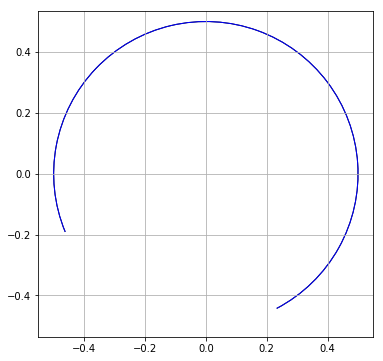

In [32]:
fig4, ax4=plt.subplots(figsize=(6,6))


arctry1 = Arc([0,0], 1.0, 1.0, theta1=-62.25130781453864, theta2=-157.5239889382019)#theta1=-62.25130781453864, theta2=t)#-62.25130781453864)#theta1 = -19.2,theta2 = 180.0+19.2)
#arctry2 = Arc([0,0], 1.0, 1.0, theta1=-62.25130781453864, theta2=-62.25130781453864+np.rad2deg(tryang), color='pink')#theta1=-62.25130781453864, theta2=t)#-62.25130781453864)#theta1 = -19.2,theta2 = 180.0+19.2)
arctry3 = Arc([0,0], 1.0, 1.0, theta1=-62.25130781453864, theta2=-62.25130781453864-95.2726811237, color='blue')
#ax4.plot([vecs[0][0], 0], [vecs[0][1], 0], color='red')
#ax4.plot([vecs[1][0], 0], [vecs[1][1], 0], color='red')
#ax4.plot([b[0], c[0]], [b[1], c[1]], color='blue')
#ax4.scatter(b[0],b[1], color='green')
#ax4.scatter(c[0],c[1], color='pink')
ax4.add_patch(arctry1)
#ax4.add_patch(arctry2)
ax4.add_patch(arctry3)
plt.axis('equal')
ax4.grid(True, which='both')
plt.show()

In [ ]:
np.rad2deg(tryang) % 180

In [81]:
def angle_between(a, b, c):
    v1_u = unit_vector(np.array(a)-np.array(b))
    v2_u = unit_vector(np.array(c)-np.array(b))
    ang1 = np.arctan2(*v1_u[::-1])
    deg1= np.rad2deg(ang1)
    print deg1
    ang2 = np.arctan2(*v2_u[::-1])
    deg2 =np.rad2deg(ang2)
    #print deg2

    thetas = [deg2, deg1]
    
    ang = np.array((ang1 - ang2) % (2 * math.pi))
    deg = (deg1-deg2) % 360
    #print deg
    #print ang
    return ang, thetas#vs

In [19]:
def unit_vector(vector):
    return (vector / np.linalg.norm(vector))

In [20]:
v1_u

NameError: name 'v1_u' is not defined